# RingWorld Results




In [46]:
using Plots; gr()
using Reproduce
using FileIO
using Statistics
using ProgressMeter

In [121]:

function get_best_setting(ic, sweep_param, clean_func)

    diff_dict = diff(ic)

    μ = zeros(length(diff_dict[sweep_param]))
    σ = zeros(length(diff_dict[sweep_param]))
    
    for (swprm_idx, swprm) ∈ enumerate(diff_dict[sweep_param])
        _, _, itms = search(ic, Dict(sweep_param=>swprm))
        res = zeros(length(itms))
        for (itm_idx, itm) ∈ enumerate(itms)
            try
                res[itm_idx] = clean_func(
                    load(joinpath(itm.folder_str, "results.jld2")))
                if isnan(res[itm_idx])
                    res[itm_idx] = Inf
                end
            catch
                println("error")
                res[itm_idx] = Inf
            end
        end
        μ[swprm_idx] = mean(res)
        σ[swprm_idx] = std(res)./sqrt(length(itms))
    end
    min_idx = findmin(μ)
    diff_dict[sweep_param][min_idx[2]], (min_idx[1], σ[min_idx[2]])
end


"""
    get_lines_sensitivity(folder_loc, sens_param, line_params, get_best_func)

Get sensitivity curves over sens_parameters using get_best_Func and line_params. 
# Arguments
-`get_best_func`: A function which takes an itemcollection and returns the best setting. Usually this will be a closure.
- `line_params`: The parameters defining each new line.
- `sens_param`: The x-axis parametere
"""
function get_lines_sensitivity(item_col, sens_param, line_params, get_best_func)

    diff_dict = diff(item_col)
    res_dict = Dict()

    @showprogress 0.1 "Line: " for line_prm ∈ Iterators.product((diff_dict[k] for k ∈ line_params)...)
        sd = Dict(line_params[i]=>line_prm[i] for i ∈ 1:length(line_params))
        _, _, _sub_itms = search(item_col, Dict(line_params[i]=>line_prm[i] for i ∈ 1:length(line_params)))
        sub_ic = ItemCollection(_sub_itms)
        sub_diff_dict = diff(sub_ic)
        μ = zeros(length(sub_diff_dict[sens_param]))
        σ = zeros(length(sub_diff_dict[sens_param]))
        for (sprm_idx, sprm) ∈ enumerate(sub_diff_dict[sens_param])
            _, _, sprm_items = search(sub_ic, Dict(sens_param=>sprm))
            _sprm_ic = ItemCollection(sprm_items)
            prm, (μ[sprm_idx], σ[sprm_idx]) = get_best_func(_sprm_ic)
        end
        res_dict[line_prm] = (μ, σ)
    end
    res_dict, diff_dict[sens_param]
end

get_lines_sensitivity(folder_str::AbstractString, sens_param, line_params, get_best_func) =
    get_lines_sensitivity(ItemCollection(folder_str), sens_param, line_params, get_best_func)

function plot_sensitivity(folder_loc_or_ic, sens_param, line_params, get_best_func, settings_dict=nothing; kwargs...)
    
    res_dict, x_axis = get_lines_sensitivity(folder_loc_or_ic, sens_param, line_params, get_best_func)
    kys = collect(keys(res_dict))
    
    if settings_dict isa Nothing
        settings_dict = Dict(k=>[:label=>"$k"] for k ∈ kys)
    end
    
    plt = if settings_dict isa Nothing
        plot(x_axis, res_dict[kys[1]][1], ribbon=res_dict[kys[1]][2]; kwargs...)
    else
        plot(x_axis, res_dict[kys[1]][1], ribbon=res_dict[kys[1]][2]; settings_dict[kys[1]]..., kwargs...)
    end
    for k ∈ kys[2:end]
        if settings_dict isa Nothing
            plot!(plt, x_axis, res_dict[k][1], ribbon=res_dict[k][2])
        else
            plot!(plt, x_axis, res_dict[k][1], ribbon=res_dict[k][2]; settings_dict[k]...)
        end
    end
    plt
end

function get_x_axis(key, res_dicts, xaxises)
    for (rd_idx, rd) in enumerate(res_dicts)
        if key ∈ keys(rd)
            return xaxises[rd_idx]
        end
    end
end


function plot_sensitivity(res_dict::Dict, x_axis::AbstractArray, settings_dict=nothing; kwargs...)
    x_axis_d = Dict(k=>x_axis for k in keys(res_dict))
    plot_sensitivity(res_dict, x_axis_d, settings_dict; kwargs...)
end


function plot_sensitivity(res_dicts::Tuple, x_axises::Tuple, settings_dict=nothing; kwargs...)
    res_dict = merge(res_dicts...)
    x_axis_d = Dict(k=>get_x_axis(k, res_dicts, x_axises) for k in keys(res_dict))
    plot_sensitivity(res_dict, x_axis_d, settings_dict; kwargs...)
end



function plot_sensitivity(res_dict::Dict, x_axis_d::Dict, settings_dict=nothing;kwargs...)


    kys = collect(keys(res_dict))
    
    if settings_dict isa Nothing
        settings_dict = Dict(k=>[:label=>"$k"] for k ∈ kys)
    end

    plt = plot(x_axis_d[kys[1]], res_dict[kys[1]][1], ribbon=res_dict[kys[1]][2]; settings_dict[kys[1]]..., kwargs...)
    for k ∈ kys[2:end]
        plot!(plt, x_axis_d[k], res_dict[k][1], ribbon=res_dict[k][2]; settings_dict[k]...)
    end
    plt
end

plot_sensitivity (generic function with 10 methods)

In [33]:
best_func(best_param, res_key) = (i2c)->get_best_setting(i2c, best_param, (d)->d["results"][res_key])

best_func (generic function with 1 method)

In [124]:
function ringworld_sens(ic_rnn, ic_gvfn, outhorde, size)
    sub_ic_rnn = ItemCollection(search(ic_rnn, Dict("size"=>size, "outhorde"=>outhorde))[3])
    sub_ic_gvfn = ItemCollection(search(ic_gvfn, Dict("size"=>size, "outhorde"=>outhorde))[3])

    rnn_res, x_axis_ro = get_lines_sensitivity(sub_ic_rnn, "truncation", ["cell"], best_func("alpha", "all"))
    gvfn_res, x_axis_go = get_lines_sensitivity(sub_ic_gvfn, "truncation", ["horde"], best_func("alpha", "all"))

    plt = plot_sensitivity((rnn_res, gvfn_res), (x_axis_ro, x_axis_go), title="All")

    rnn_res, x_axis_ro = get_lines_sensitivity(sub_ic_rnn, "truncation", ["cell"], best_func("alpha", "end"))
    gvfn_res, x_axis_go = get_lines_sensitivity(sub_ic_gvfn, "truncation", ["horde"], best_func("alpha", "end"))

    plt2 = plot_sensitivity((rnn_res, gvfn_res), (x_axis_ro, x_axis_go), title="End")

    plot(plt, plt2, layout=(2, 1), size=(800, 600), plot_title=string((size, outhorde)))
end

ringworld_sens (generic function with 1 method)

In [125]:
ic_rnn = ItemCollection("../../../compute_canada/ringworld_rnn/data");
ic_gvfn = ItemCollection("../../../compute_canada/ringworld_gvfn/data");

# Onestep

Line: 100%|█████████████████████████████████████████████| Time: 0:00:02
Line: 100%|█████████████████████████████████████████████| Time: 0:00:03
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


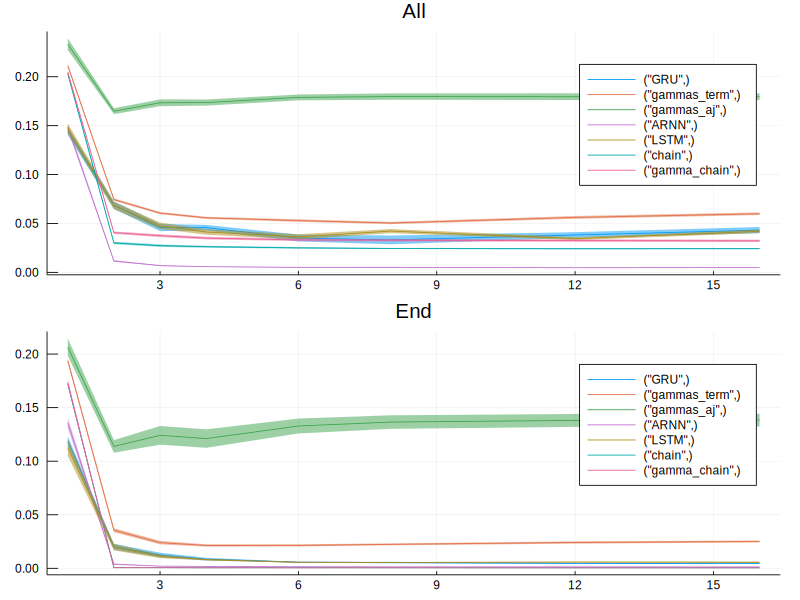

In [126]:
ringworld_sens(ic_rnn, ic_gvfn, "onestep", 6)

Line: 100%|█████████████████████████████████████████████| Time: 0:00:02
Line: 100%|█████████████████████████████████████████████| Time: 0:00:03
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:02


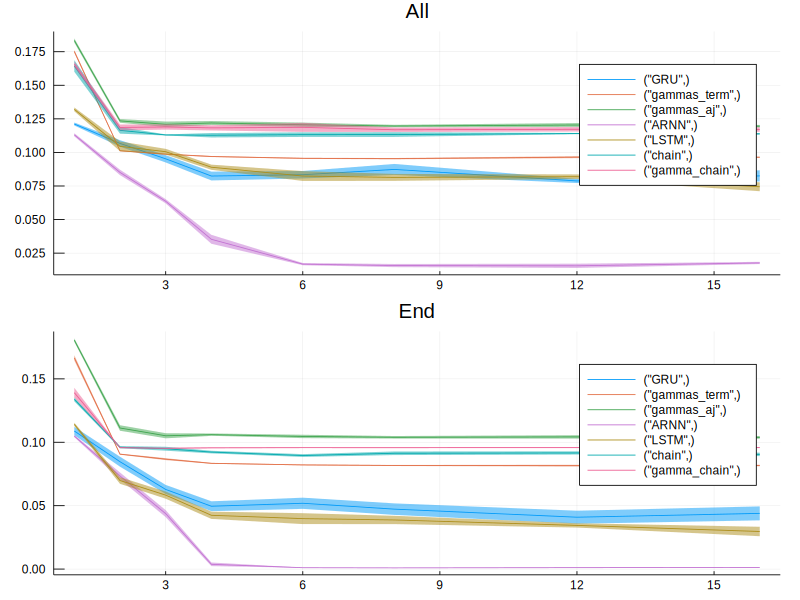

In [127]:
ringworld_sens(ic_rnn, ic_gvfn, "onestep", 10)

# gammas_term

Line: 100%|█████████████████████████████████████████████| Time: 0:00:03
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:02


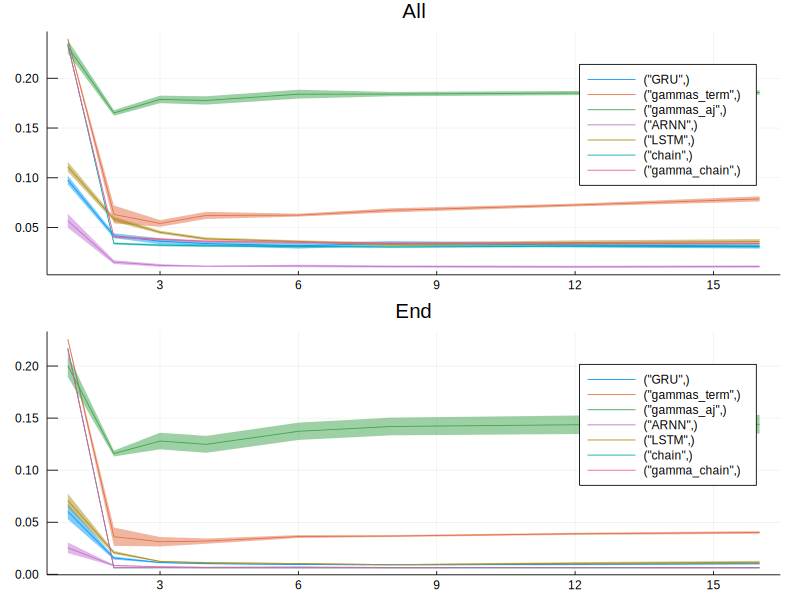

In [128]:
ringworld_sens(ic_rnn, ic_gvfn, "gammas_term", 6)

Line: 100%|█████████████████████████████████████████████| Time: 0:00:03
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:02


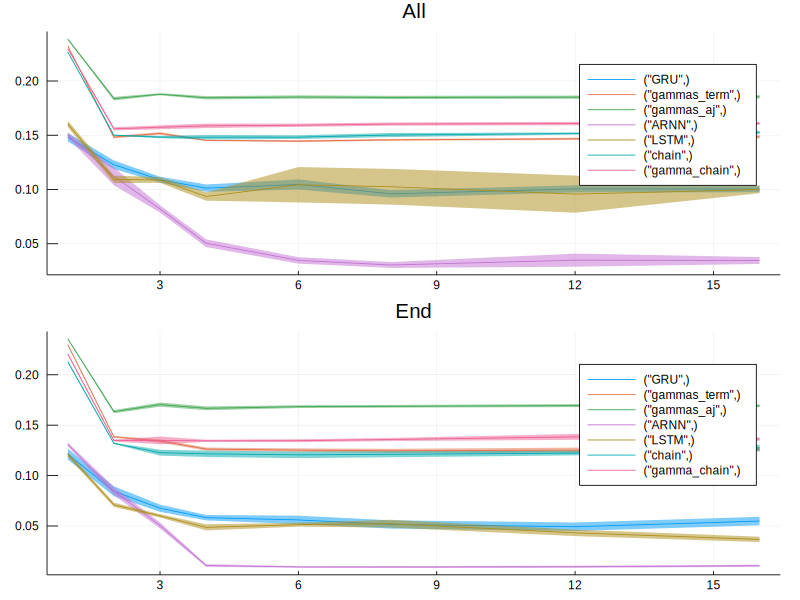

In [129]:
ringworld_sens(ic_rnn, ic_gvfn, "gammas_term", 10)

# RMSProp

In [59]:
ic_rnn_rmsprop = ItemCollection("../../../compute_canada/ringworld_rnn_rmsprop/data");
ic_gvfn_rmsprop = ItemCollection("../../../compute_canada/ringworld_gvfn_rmsprop/data");

## Onestep

Line: 100%|█████████████████████████████████████████████| Time: 0:00:03
Line: 100%|█████████████████████████████████████████████| Time: 0:00:05
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:02


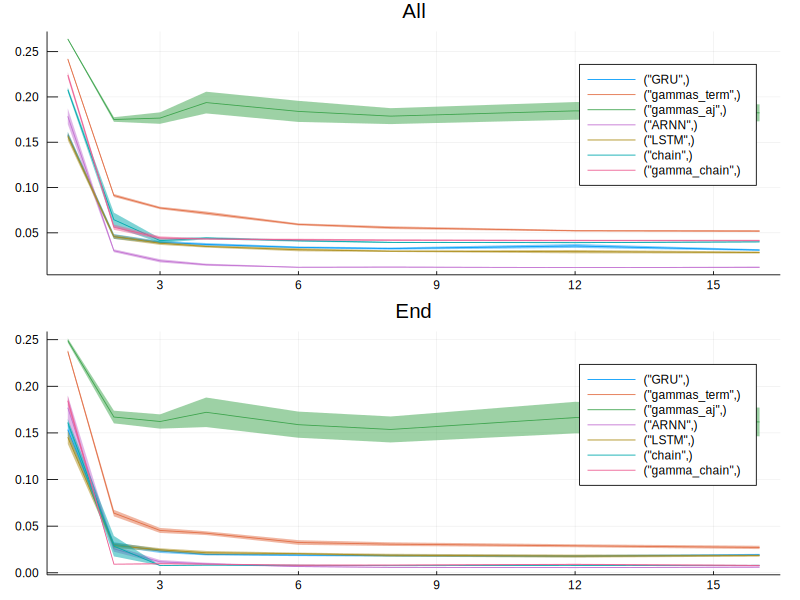

In [109]:
ringworld_sens(ic_rnn_rmsprop, ic_gvfn_rmsprop, "onestep", 6)

Line: 100%|█████████████████████████████████████████████| Time: 0:00:03
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:02


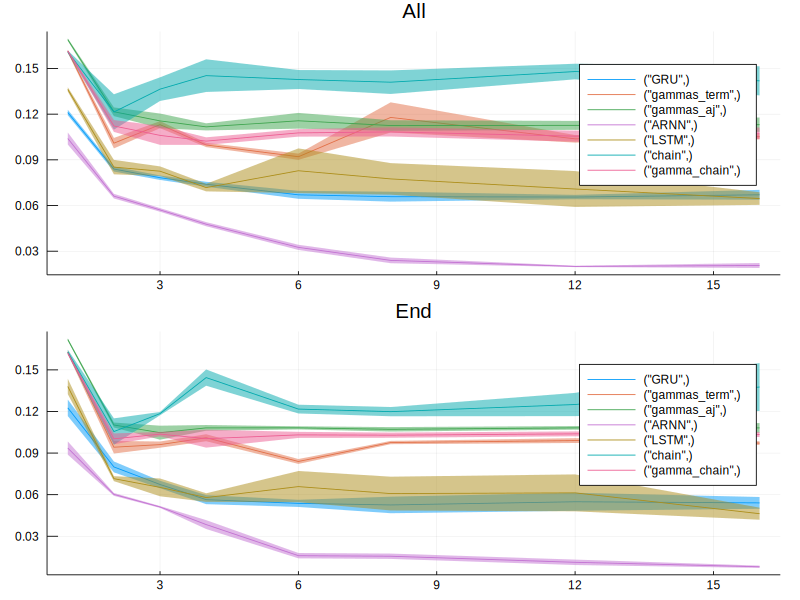

In [110]:
ringworld_sens(ic_rnn_rmsprop, ic_gvfn_rmsprop, "onestep", 10)

## GammasTerm

Line: 100%|█████████████████████████████████████████████| Time: 0:00:03
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:02


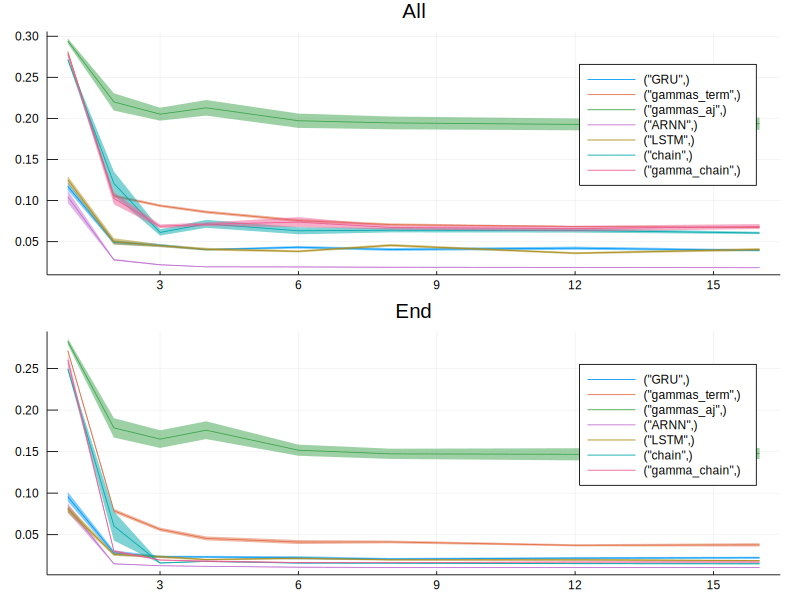

In [111]:
ringworld_sens(ic_rnn_rmsprop, ic_gvfn_rmsprop, "gammas_term", 6)

Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:02


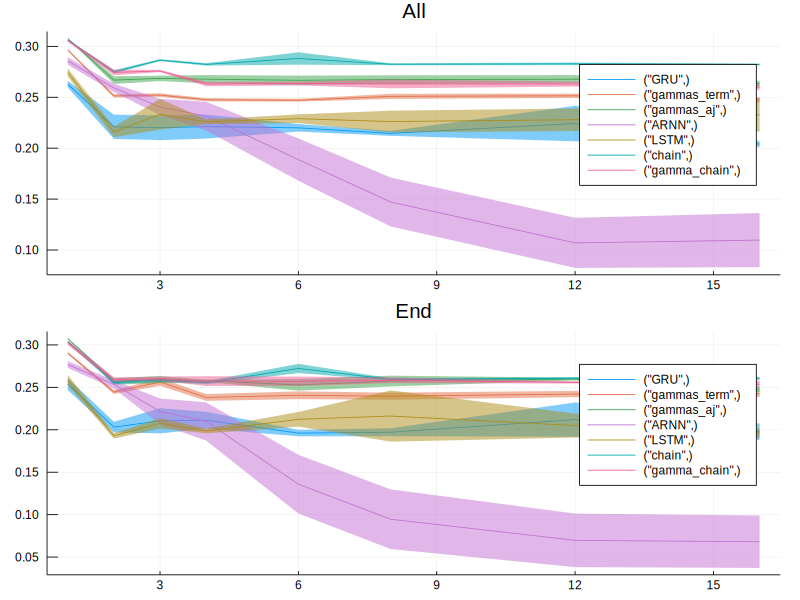

In [112]:
ringworld_sens(ic_rnn_rmsprop, ic_gvfn_rmsprop, "gammas_term", 10)

# Forecat Networks

In [72]:
ic_fore = ItemCollection("../../../compute_canada/ringworld_forecast/data");
diff(ic_fore)

Dict{String,Array} with 8 entries:
  "hidden"     => [14, 22]
  "alpha"      => [0.00877915, 0.0131687, 0.0197531, 0.0296296, 0.0444444, 0.06…
  "truncation" => [1, 2, 3, 4, 6, 8, 12, 16]
  "outhorde"   => ["gammas_term", "onestep"]
  "klength"    => [14, 22]
  "seed"       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "size"       => [6, 10]
  "cell"       => ["ARNNCell", "GRUCell", "LSTMCell"]

In [86]:
diff(search(ic_fore, Dict("size"=>size, "outhorde"=>"onestep"))[3])

Dict{String,Array} with 5 entries:
  "alpha"      => [0.00877915, 0.0131687, 0.0197531, 0.0296296, 0.0444444, 0.06…
  "truncation" => [1, 2, 3, 4, 6, 8, 12, 16]
  "klength"    => [14, 22]
  "seed"       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "cell"       => ["ARNNCell", "GRUCell", "LSTMCell"]

Line: 100%|█████████████████████████████████████████████| Time: 0:00:03
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:48
Line: 100%|█████████████████████████████████████████████| Time: 0:00:02
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04


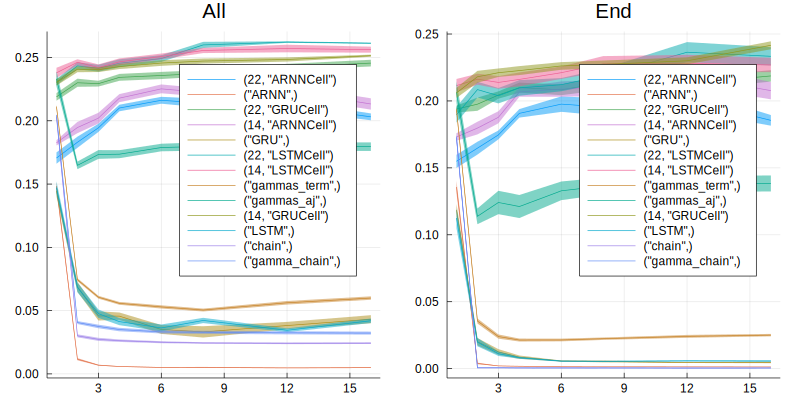

In [75]:
begin
    size = 6
    outhorse = "onestep"
    sub_ic_rnn = ItemCollection(search(ic_rnn, Dict("size"=>size, "outhorde"=>outhorde))[3])
    sub_ic_gvfn = ItemCollection(search(ic_gvfn, Dict("size"=>size, "outhorde"=>outhorde))[3])
    sub_ic_fore = ItemCollection(search(ic_fore, Dict("size"=>size, "outhorde"=>outhorde))[3])

    rnn_res, x_axis_ro = get_lines_sensitivity(sub_ic_rnn, "truncation", ["cell"], best_func("alpha", "all"))
    gvfn_res, x_axis_go = get_lines_sensitivity(sub_ic_gvfn, "truncation", ["horde"], best_func("alpha", "all"))
    fore_res, x_axis_fo = get_lines_sensitivity(sub_ic_fore, "truncation", ["klength", "cell"], best_func("alpha", "all"))

    plt = plot_sensitivity_from_lines((rnn_res, gvfn_res, fore_res), (x_axis_ro, x_axis_go, x_axis_fo), title="All")

    rnn_res, x_axis_ro = get_lines_sensitivity(sub_ic_rnn, "truncation", ["cell"], best_func("alpha", "end"))
    gvfn_res, x_axis_go = get_lines_sensitivity(sub_ic_gvfn, "truncation", ["horde"], best_func("alpha", "end"))
    fore_res, x_axis_fo = get_lines_sensitivity(sub_ic_fore, "truncation", ["klength", "cell"], best_func("alpha", "end"))

    plt2 = plot_sensitivity_from_lines((rnn_res, gvfn_res, fore_res), (x_axis_ro, x_axis_go, x_axis_fo), title="End")

    plot(plt, plt2, grid=(2, 1), size=(800, 400), plot_title=string((size, outhorde)))
end

Line: 100%|█████████████████████████████████████████████| Time: 0:00:03
Line: 100%|█████████████████████████████████████████████| Time: 0:00:03


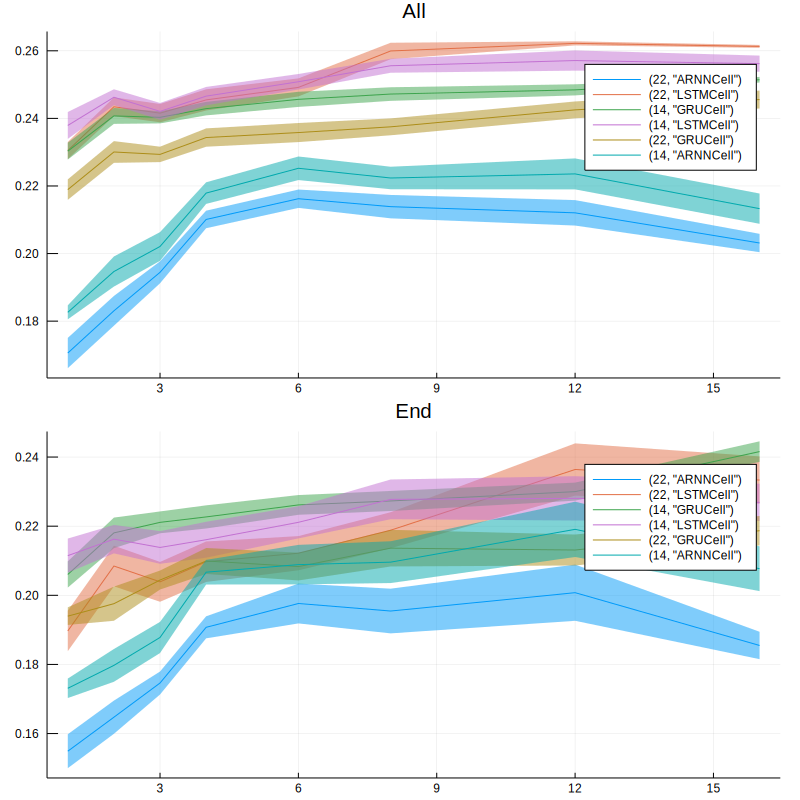

In [116]:
begin
    size = 6
    outhorse = "onestep"
    sub_ic_fore = ItemCollection(search(ic_fore, Dict("size"=>size, "outhorde"=>outhorde))[3])

    fore_res, x_axis_fo = get_lines_sensitivity(sub_ic_fore, "truncation", ["klength", "cell"], best_func("alpha", "all"))

    plt = plot_sensitivity(fore_res, x_axis_fo, title="All")

    fore_res, x_axis_fo = get_lines_sensitivity(sub_ic_fore, "truncation", ["klength", "cell"], best_func("alpha", "end"))

    plt2 = plot_sensitivity(fore_res, x_axis_fo, title="End")

    plot(plt, plt2, layout=(2, 1), size=(800, 800), plot_title=string((size, outhorde)))
end

Line: 100%|█████████████████████████████████████████████| Time: 0:00:03
Line: 100%|█████████████████████████████████████████████| Time: 0:00:03


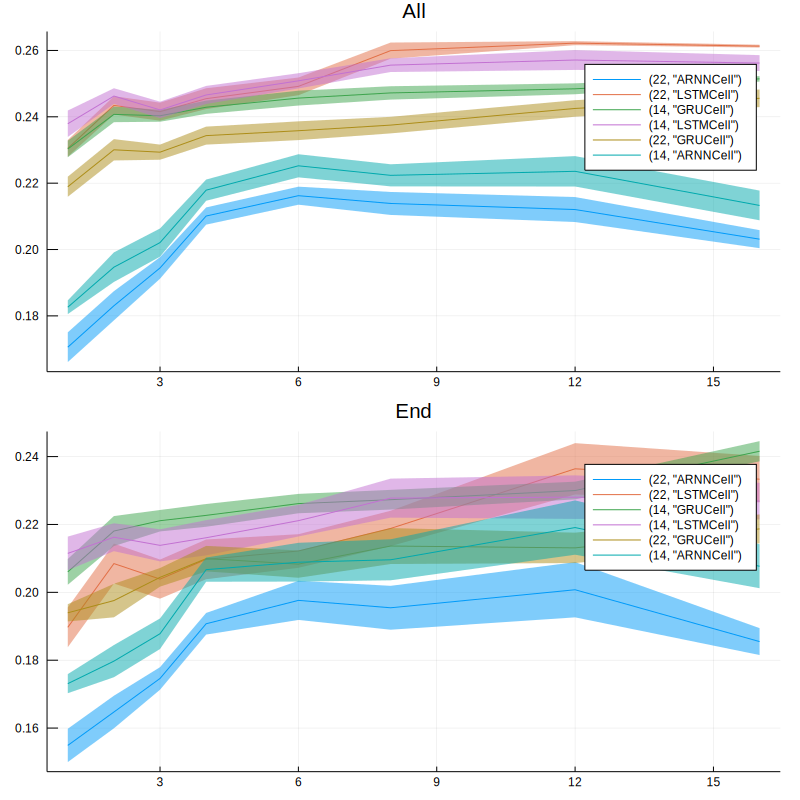

In [117]:
begin
    size = 6
    outhorse = "gammas_term"
    sub_ic_fore = ItemCollection(search(ic_fore, Dict("size"=>size, "outhorde"=>outhorde))[3])

    fore_res, x_axis_fo = get_lines_sensitivity(sub_ic_fore, "truncation", ["klength", "cell"], best_func("alpha", "all"))

    plt = plot_sensitivity(fore_res, x_axis_fo, title="All")

    fore_res, x_axis_fo = get_lines_sensitivity(sub_ic_fore, "truncation", ["klength", "cell"], best_func("alpha", "end"))

    plt2 = plot_sensitivity(fore_res, x_axis_fo, title="End")

    plot(plt, plt2, layout=(2, 1), size=(800, 800), plot_title=string((size, outhorde)))
end

In [91]:
ic_fore_rmsprop = ItemCollection("../../../compute_canada/ringworld_forecast_rmsprop/data");

Line: 100%|█████████████████████████████████████████████| Time: 0:00:03
Line: 100%|█████████████████████████████████████████████| Time: 0:00:03


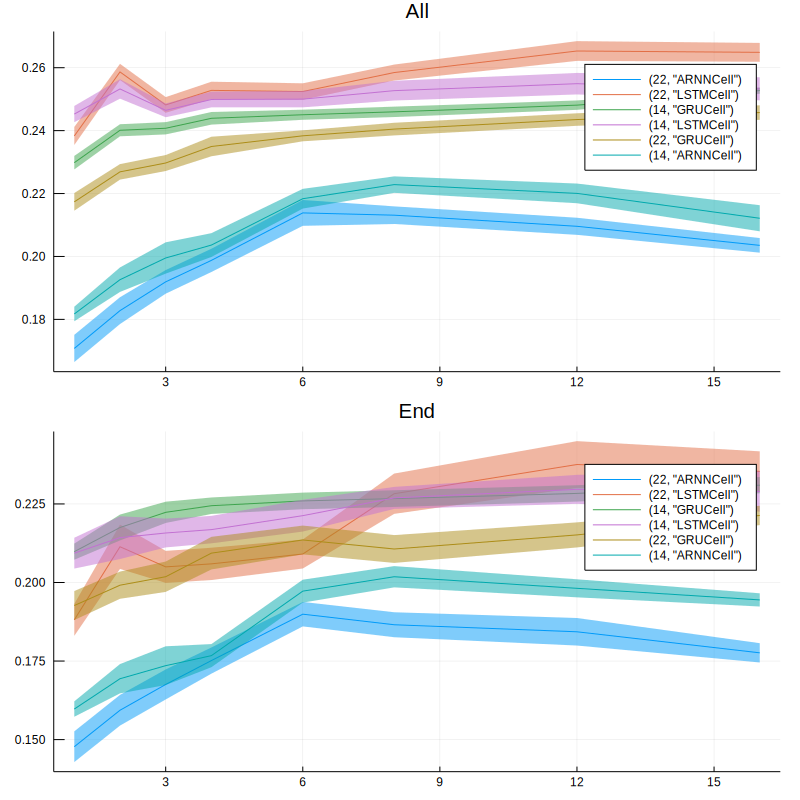

In [118]:
begin
    size = 6
    outhorse = "onestep"
    sub_ic_fore = ItemCollection(search(ic_fore_rmsprop, Dict("size"=>size, "outhorde"=>outhorde))[3])

    fore_res, x_axis_fo = get_lines_sensitivity(sub_ic_fore, "truncation", ["klength", "cell"], best_func("alpha", "all"))

    plt = plot_sensitivity(fore_res, x_axis_fo, title="All")

    fore_res, x_axis_fo = get_lines_sensitivity(sub_ic_fore, "truncation", ["klength", "cell"], best_func("alpha", "end"))

    plt2 = plot_sensitivity(fore_res, x_axis_fo, title="End")

    plot(plt, plt2, layout=(2, 1), size=(800, 800), plot_title=string((size, outhorde)))
end